<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/GymFrozenLakeDoubleQLearning-Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning
## Appliqué à [Gym.OpenAI](https://gym.openai.com)

---
## Test de ML par Double Q-Learning pour atteindre l'objectif

**Utilisation de l'environnement Gym**
 (voir la page d'introduction à [Gym](https://gym.openai.com)).

#### Si besoin, importer gym

In [1]:
#!pip install gym

#### L'environnement FrozenLake

In [1]:
import gym

---
- Utiliser l'environnement `FrozenLake8x8-v1` (un labyrinthe en mode texte)
  - **ATTENTION**, avec d'ancienne version de gym (sous colab, ...), il faut utiliser la version 0 (`FrozenLake8x8-v0`)
- 4 actions sont possibles (Left(0), Down(1), Right(2), Up(3))
  - l'adjectif "Frozen" signifie qu'une *action n'est pas déterministe !*
    - à partir d'une case "gelée", aller à droite peut .. mener à droite, ou pas
    - => intérêt du Q-Learning adapté à ce type d'environnement probabiliste
- Le labyrinthe est ainsi composé de zones glacées, de puits, et d'un objectif


**N.B.** 
  - *Cet environnement fonctionne bien sous colab, jupyterlab.. quelques soucis de l'affichage de l'état courant (carré rouge) sous Pyzo....* 
  - Il est fortement conseillé de débuter avec un environnement déterministe pour évaluer la bonne marche de l'algo de Q-Learning que vous aurez développer..

---
#### Etude de l'environnement

In [2]:
env = gym.make('FrozenLake-v1', is_slippery=False) # tester FrozenLake8x8 pour l'environnement plus large
print("specification de l'environnement : ", env.spec)
print("espace d'actions : ", env.action_space , " => 4 actions \"discretes\" (non continues)") #ici 4 actions discrétisée
print("espace d'etats : ", env.observation_space , " => 16 etats distincts") #ici 4x4 cellules possibles

env.reset()
print("Environnement et etat initial (en rouge) : ")
env.render()
print("S = Start (pos 0), G = Goal (pos 15), H = Hole, F = Frozen place")

specification de l'environnement :  EnvSpec(FrozenLake-v1)
espace d'actions :  Discrete(4)  => 4 actions "discretes" (non continues)
espace d'etats :  Discrete(16)  => 16 etats distincts
Environnement et etat initial (en rouge) : 

SFFF
FHFH
FFFH
HFFG
S = Start (pos 0), G = Goal (pos 15), H = Hole, F = Frozen place


---
#### Test des actions

Sous Gym, `step` permet d'effectuer une action. 
En retour la fonction retourne une observation sur l'etat d'arrivee, sa recompense, son type (final ou non), et des informations.
Ici, dans FrozenLake, 
- observation = position où se trouve l'agent
- reward = recompense
- done = vrai si but atteint
- info = probabilité de succès de l'action 
  - en mode déterministe, sol non glissant, la proba de réussite est de 100%
  - en mode non déterministe, sol glissant, la proba de réussite est de 30%

In [3]:
###### Test des actions
env.reset()
##on se met sur la case 6 (plutôt que la case 0 par défaut)
env.env.s = 6
action = 0
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Left)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 5 ,gain: 0.0 ,fini: True , {'prob': 1.0}


In [4]:
env.reset()
##on se met sur la case 6 (plutôt que la case 0 par défaut)
env.env.s = 6
action = 1
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Down)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 10 ,gain: 0.0 ,fini: False , {'prob': 1.0}


In [5]:
env.reset()
##on se met sur la case 6 (plutôt que la case 0 par défaut)
env.env.s = 6
action = 2
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Right)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 7 ,gain: 0.0 ,fini: True , {'prob': 1.0}


In [6]:
env.reset()
##on se met sur la case 6 (plutôt que la case 0 par défaut)
env.env.s = 6
action = 3
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Up)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 2 ,gain: 0.0 ,fini: False , {'prob': 1.0}


---
**Cas non déterministe**

L'environnement FrozenLake peut également être chargé en mode non déterministe : chaque état est une case gelée, et chaque action qui s'y deroule n'a qu'une chance sur trois de réussir ! Et 2 chances sur 3 de mener ailleurs !!

Chargeons l'environnement dans ce mode et testons les actions à partir de l'état initial : 

In [7]:
env = gym.make('FrozenLake-v1', is_slippery=True) 

env.reset()
env.env.s = 6
action = 0
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Left)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 2 ,gain: 0.0 ,fini: False , {'prob': 0.3333333333333333}


In [8]:
env.reset()
env.env.s = 6
action = 1
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Down)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 7 ,gain: 0.0 ,fini: True , {'prob': 0.3333333333333333}


In [9]:
env.reset()
env.env.s = 6
action = 2
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Right)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 10 ,gain: 0.0 ,fini: False , {'prob': 0.3333333333333333}


In [10]:
env.reset()
env.env.s = 6
action = 3
observation, reward, done, info = env.step(action)
env.render()
print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Up)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 5 ,gain: 0.0 ,fini: True , {'prob': 0.3333333333333333}


On est clairement ici dans un environnement non déterministe (une même action à partir d'un même état ne mène pas toujours au même résultat); c'est le contexte de prédilection de l'algo de Q-Learning...

---
### <font color="red">Premiere résolution en mode déterministe</font>
Important, pour valider l'apprentissage de votre algorithme avant de passer en mode non-déterministe, il vaut mieux le tester sur un environnement où chaque action à 100% de réussite. Ci-dessous un exemple sur le mini labyrinthe.

In [11]:
env = gym.make('FrozenLake-v1', is_slippery=False)
env.reset()
actions = [2,2,1,1,1,2]
for a in actions:
    observation, reward, done, info = env.step(a)
    env.render()
    print("pos° actuelle:", observation,",gain:", reward,",fini:", done,",", info)

  (Right)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 1 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Right)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 2 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Down)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 6 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Down)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 10 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Down)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 14 ,gain: 0.0 ,fini: False , {'prob': 1.0}
  (Right)
SFFF
FHFH
FFFH
HFFG
pos° actuelle: 15 ,gain: 1.0 ,fini: True , {'prob': 1.0}


---
## L'algorithme de Double Q-Learning

In [12]:
import numpy as np
import random as rnd

env = gym.make('FrozenLake8x8-v1', is_slippery=False)

actions = {0:'Gauche', 1:'Bas', 2:'Droite', 3:'Haut'}

#### Mise en place des paramètres
L'algo de **double** Q Learning simple repose sur DEUX matrices nb_etats x nb_actions; la mise à jour des valeurs d'une action dans une grille utilise la valeur de la meilleure action suivante dans l'autre matrice.

On réalise, plus ou moins alternativement :

$a^* \gets  argmax_{a} QA(s', a)$,

$QA(s,a) \gets QA(s,a) + \lambda \times (r + \gamma \times QB(s', a^*))-  QA(s,a))$ 

ou

$b^* \gets  argmax_{a} QB(s', a)$

$QB(s,a) \gets QB(s,a) + \lambda \times (r + \gamma \times QA(s', b^*))-  QB(s,a))$ 

avec
  - $\lambda$ : coef d'apprentissage
  - $\gamma$ : coef de réduction 
  - $r$ : récompense
  
Cette équation donne la qualité de l'action *a* à partir de l'état *s*.

Initialement, à chaque état, une action est choisie aléatoirement (car toutes "valent" 0); puis au fil des tests les actions les plus valuées sont choisies. 

*Vous pouvez voir en fin de cette page des aides sur les fonctionnalités Python utiles pour la manipulation de tableaux.*

In [22]:
# initialiser la Q-Table
# autant de cases que l'environnement en possède, 
# contenant autant de valeurs que d'actions possibles
# donc ici une matrice 64 x 4
QA = np.zeros([env.observation_space.n,env.action_space.n])
QB = np.zeros([env.observation_space.n,env.action_space.n])

lambda_learn = .1
gamma = 0.7

___
#### L'algorithme de Double Q-Learning 

In [23]:
##algorithme de Q-Learning simple
def q_learn(nb_steps=64):
    """
    effectue un cycle d'apprentissage/recherche de solution' via le double Q-Learning

    Parameters
    ----------
    nb_steps : nb de tests d'actions

    Returns
    -------
    total_r : recompense totale
    r : recompense du dernier etat rencontre
    states_list : liste des etats traverses
    actions_list : liste des actions effectuees

    """
    s = env.reset()
    total_r = 0
    done = False
    step = 0
    states_list = []
    actions_list = []
    best_next_a = best_next_b = 0
    best_ab = None
    # The Q-Table learning algorithm
    while not done and step < nb_steps:
        step += 1
        # find the best actions values ammong the actions available at the current state, from QA & QB
        best_ab = np.max([QA[s, :], QB[s, :]], axis=0)
        # list of the actions with the maximum value in QA or QB
        max_a = np.where(best_ab == np.max(best_ab))[0]
        # choose one of the best action   
        # initially, all the action has a 0 value; so initially the algo explores
        # when there are sufficient values, the algo reinforces the actions
        a = np.random.choice(max_a, 1)[0]
        # play the action and get new state and reward from environment
        sprime, r, done, _ = env.step(a)
        # Q-Learning, play sometimes whith QA, or QB 
        if(rnd.randint(0,1)==0):            
            best_next_a = np.argmax(QA[sprime, :])
            QA[s, a] = QA[s, a] + lambda_learn*(r + gamma * QB[sprime, best_next_a] - QA[s, a])
        else:
            best_next_b = np.argmax(QB[sprime, :])
            QB[s, a] = QB[s, a] + lambda_learn*(r + gamma * QA[sprime, best_next_b] - QB[s, a])

        s = sprime
        total_r = total_r + r
        states_list.append(s)
        actions_list.append(a)
    return total_r, r, states_list, actions_list

In [24]:
def try_qlearn(nb_tests=2000, nb_steps=64):
    """
    lance nb_episodes fois un cycle de Q-Learning et memorise chaque solution trouvee

    Returns
    -------
    solutions_list : liste des solutions (no, recompense totale, liste des etats, liste des actions)
    """
    states_list = []
    actions_list = []
    solutions_list = []
    epsilon = 1
    for i in range(nb_tests):
        # Reset environment and get first new observation
        total_r, r, states_list, actions_list = q_learn(nb_steps)
        # memorize if a solution has been found
        if r == 1: solutions_list.append((i, total_r, states_list, actions_list))
        
    if(len(solutions_list) == 0): print("aucune solution trouvee !!")

    return solutions_list


## Affichage de du résultat
Affichons maintenant la liste des actions via l'environnement Gym

In [25]:
def rendu(solutions_list):
    """ affiche la plus courte sequence d'actions permettant d'atteindre l'objectif q partir des solutions fournies
    Parameters
    ----------
    solutions_list : liste des solutions trouvees

    Returns
    -------
    None.
    """
    mini_sol = solutions_list[0]
    for s in  solutions_list:
        if len(s[2]) < len(mini_sol[2]): mini_sol = s
    print("une solution en ", len(mini_sol[2]), " etapes : ")
    env.reset()
    env.render()
    for i in range(0, len(mini_sol[2])):
        env.env.s = mini_sol[2][i]
        print("action ", actions[mini_sol[3][i]])
        env.render()

In [26]:
##ON LANCE LA RESOLUTION : 
solutions = try_qlearn(3000, 64)
if(len(solutions)>0):rendu(solutions)
#relancer le bloc si pas de solution trouvee

une solution en  14  etapes : 

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFF

Le gain est intéressant. Si on doit parcrourir tout l'arbre de recherche, la complexité de l'arbre est borné par $4 \times 4 \times \dots \times 4 = 4^{63} = 85 070 591 730 234 615 865 843 651 857 942 052 864$ solutions à balayer (85 millards de millards de millards de millards de solutions)..

Ici, au plus $3000 \times 64 = 192 000$ actions on été testées..

Traçons une courbe pour évaluer la progression de l'apprentissage entre chaque test

In [27]:
import matplotlib.pyplot as plt
def plot_frequence_sol(solutions_list):
    """
    dessine la frequence de solution trouvees
    Parameters
    ----------
    solutions : liste des solutions

    Returns
    -------
    None.

    """
    xs = [x[0] for x in solutions_list]
    ys = [y[1] for y in solutions_list]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys, '.')
    plt.show()



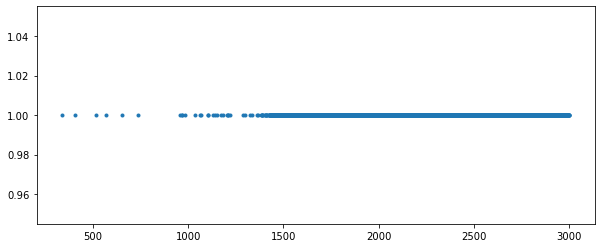

In [28]:
plot_frequence_sol(solutions)

In [29]:
##on regarde ce qu'il y a dans une des matrices : 
np.round(QA, 2)

array([[0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.03, 0.  ],
       [0.  , 0.  , 0.04, 0.  ],
       [0.  , 0.  , 0.06, 0.  ],
       [0.  , 0.08, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.12, 0.  ],
       [0.  , 0.  , 0.17, 0.  ],
       [0.  , 0.24, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.

---
### <font color="red">Test de résolution en mode non déterministe</font>
Rechargeons l'environnement en mode "glissant".

Il suffit de réinitialiser la table Q et de lancer l'algorithme...


une solution en  16  etapes : 

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Haut

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Haut

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Droite

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Haut

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Haut

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
action  Bas

SFFFFFFF
FFFFFFFF
FFFHF

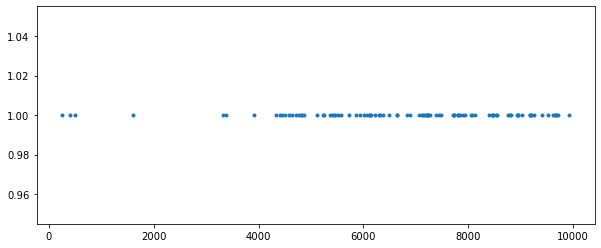

In [30]:
env = gym.make('FrozenLake8x8-v1', is_slippery=True)

env.reset()
QA = np.zeros([env.observation_space.n,env.action_space.n])
QB = np.zeros([env.observation_space.n,env.action_space.n])
lambda_learn = .1
gamma = 0.9
##ON LANCE LA RESOLUTION : 
solutions = try_qlearn(10000, 50)
if(len(solutions)>0):rendu(solutions)
plot_frequence_sol(solutions)

Plus on relance les tests, plus on a de chance de trouver une solution...

In [31]:
##on regarde ce qu'il y a dans une des matrices : 
np.round(QB, 2)

array([[0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.01],
       [0.  , 0.02, 0.  , 0.  ],
       [0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.

----
### <font color="red">CORRECTION (travail à faire)</font>

Un des problèmes de l'algo présenté ici est l'abandon assez rapide de l'exploration car dès qu'une action a une utilité plus grande que les autres, elle sera toujours choisie.

Modifier légèrement le code précédent pour ajouter cette notion d'aléatoire...
Cela peut être rapide (2 lignes à modifier) ou légèrement plus long..

Quel est l'impact dans la résolution dans un environnement déterministe ? non déterministe ?


___
### AIDE : Les outils de Python
#### Récupérer la meilleure action
`argmax(tab)` retourne l'indice de la plus grande valeur du tableau.

`argmax(Q[2])` retourne donc le no de l'action la plus intéressante à partir de l'état 2.

In [15]:
tab1=np.array([[9,3,1], [2,6,9]], float)
print(np.argmax(tab1[1]))

2


In [16]:
tab2 = np.array([[0,5,9], [9,8,7]], float)

#### Construire un tableau reprenant les valeurs maxi de 2 tableaux

In [17]:
#fusion des valeurs max de la 1ere ligne de tab1 & tab2
maxis = np.max([tab1[0, :], tab2[0, :]], axis=0)

In [18]:
print("fusion des valeurs maxi entre ", tab1[0, :], " et ", tab2[0, :]," = ", maxis)

fusion des valeurs maxi entre  [9. 3. 1.]  et  [0. 5. 9.]  =  [9. 5. 9.]


#### Indices des plus hautes valeurs d'un tableau

In [19]:
val_max = np.max(maxis)
print("val_max dans ", maxis, " = ", val_max)
max_i = np.where(maxis == val_max)[0]
print("indices où se trouve le max = ", max_i)

val_max dans  [9. 5. 9.]  =  9.0
indices où se trouve le max =  [0 2]


In [20]:
### Choix d'une valeur dans un tableau
np.random.choice(max_i, 1)

array([0])

In [34]:
#### générer un tableau avec des valeurs aléatoires
mat = np.random.random((2,3))
print(mat)

[[0.34249034 0.91912667 0.14298058]
 [0.20880007 0.84881274 0.17893182]]


In [35]:
mat = mat / 100.
print(mat)

[[0.0034249  0.00919127 0.00142981]
 [0.002088   0.00848813 0.00178932]]
